<a href="https://colab.research.google.com/github/viniciusrpb/cic0193_machinelearning/blob/main/cap2_3_feature_extraction_sift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
#from google.colab import drive
#drive.mount('/content/drive',force_remount=True)

In [17]:
#cp -r "/content/drive/My Drive/leafs" "leafs"

In [18]:
#!pip uninstall opencv-python
#!pip uninstall opencv-contrib-python


#!pip3 install opencv-python==3.4.2.17
#!pip3 install opencv-contrib-python==3.4.2.17

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
from imageio import imread
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from skimage import feature
import cv2
import csv

In [20]:
# BOF parameters
tam_patch = (15, 15)
n_patches = 250
path_imgs = 'leafs/leaf1/'
random_state = 1


# get list of files
l_imgs = listdir(path_imgs)
# total of images
n_imgs = len(l_imgs)

dico = []

for img_path in l_imgs:

  img = cv2.imread(path_imgs+img_path)

  #gray = cv2.cvtColor(img)

  sift = cv2.xfeatures2d.SIFT_create()
  kp, des = sift.detectAndCompute(img,None)

  for d in des:
    dico.append(d)

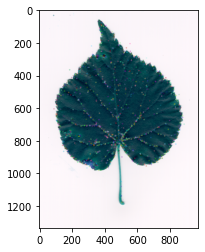

In [21]:
sample = cv2.imread('/content/leafs/leaf12/img1.png')  
grays = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create()
keypoints_1, descriptors_1 = sift.detectAndCompute(sample,None)

sample = cv2.drawKeypoints(sample,keypoints_1,grays)
plt.imshow(sample)

In [22]:
n_dic = 50 # size of the dictionary
random_state = 1

# Define a KMeans clustering model
kmeans_model = KMeans(n_clusters=n_dic, 
                      verbose=False, 
                      init='random',
                      random_state=random_state, 
                      n_init=3)

In [39]:
n_classes = 1
k = np.size(n_classes) * 10

batch_size = np.size(os.listdir(path_imgs)) * 3
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, verbose=1).fit(dico)

kmeans.verbose = False

histo_list = []

for img_path in l_imgs:

  img = cv2.imread(path_imgs+img_path)
  kp, des = sift.detectAndCompute(img, None)

  histo = np.zeros(k)
  nkp = np.size(kp)

  for d in des:
    idx = kmeans.predict([d])
    histo[idx] += 1/nkp # Because we need normalized histograms, I prefere to add 1/nkp directly

  histo_list.append(histo)

Init 1/3 with method: k-means++
Inertia for init 1/3: 53990098.025931
Init 2/3 with method: k-means++
Inertia for init 2/3: 53534654.979376
Init 3/3 with method: k-means++
Inertia for init 3/3: 54402196.896491
Minibatch iteration 1/85100: mean batch inertia: 83029.571070, ewa inertia: 83029.571070 
Minibatch iteration 2/85100: mean batch inertia: 82619.493443, ewa inertia: 83028.606449 
Minibatch iteration 3/85100: mean batch inertia: 80196.092994, ewa inertia: 83021.943557 
Minibatch iteration 4/85100: mean batch inertia: 83018.217934, ewa inertia: 83021.934794 
Minibatch iteration 5/85100: mean batch inertia: 84497.300821, ewa inertia: 83025.405281 
Minibatch iteration 6/85100: mean batch inertia: 79345.094338, ewa inertia: 83016.748125 
Minibatch iteration 7/85100: mean batch inertia: 80198.335335, ewa inertia: 83010.118403 
Minibatch iteration 8/85100: mean batch inertia: 81374.630881, ewa inertia: 83006.271263 
Minibatch iteration 9/85100: mean batch inertia: 77808.329754, ewa ine

In [43]:
import pandas as pd

X = np.array(histo_list)

print(len(histo_list))

attributes = []
for x in range(1,11):
  attributes.append("attrib_"+str(x))

df = pd.DataFrame(X, columns = attributes)

75


In [44]:
df

,attrib_1,attrib_2,attrib_3,attrib_4,attrib_5,attrib_6,attrib_7,attrib_8,attrib_9,attrib_10
0,0.077279,0.149934,0.069353,0.188243,0.086526,0.088507,0.093131,0.092470,0.077279,0.077279
1,0.112236,0.154554,0.098436,0.212511,0.033119,0.113155,0.064397,0.053358,0.083717,0.074517
2,0.116216,0.207658,0.054955,0.151351,0.065766,0.153604,0.069369,0.058108,0.062162,0.060811
3,0.111563,0.108658,0.084253,0.203951,0.049971,0.115630,0.069146,0.065660,0.085997,0.105171
4,0.131496,0.114405,0.050576,0.137077,0.086153,0.122079,0.113010,0.084060,0.073596,0.087548
...,...,...,...,...,...,...,...,...,...,...
70,0.118897,0.160253,0.070649,0.162550,0.055715,0.126364,0.068926,0.052269,0.069500,0.114877
71,0.084025,0.147303,0.056535,0.145747,0.062241,0.086618,0.076763,0.058610,0.066909,0.215249
72,0.108555,0.116008,0.059948,0.139987,0.076150,0.116008,0.076474,0.066753,0.069345,0.170771
73,0.103129,0.134415,0.075319,0.170336,0.050985,0.108343,0.068366,0.066049,0.073581,0.149479
